# Recomendador para series de anime. Entrega Final
__Emilio Lizama, Alonso Reyes, Juan-Pablo Silva__

## 1. Introducción

En la última década, la cultura japonesa ha comenzado a despertar un interés creciente en occidente. Cada vez más gente está interesada en visitar Japón, leer su literatura, y cómo no, ver sus series de televisión animadas: anime.
El anime es un término usado para referirse a la animación japonesa, la cual puede tener temáticas infantiles, acción o temas más complejos, dirigidos a audiencias adultas.

Aun así con todo este aumento de personas interesadas y viendo anime, no existe alguna página web o aplicación que analice gustos y trate de recomendar series que probablemente serán de agrado de quien las buscó. Actualmente las páginas más populares para llevar registro de qué anime se han visto solo recomiendan anime de forma general por sus puntuaciones totales, o los clásicos "porque viste A te podría gustar B", cosas que son cálculos sencillos hechos acorde a los distintos géneros de cada serie y si coinciden con otras, de preferencia de mayor puntuación. Es por esto que nosotros creamos un sistema recomendador, que actúe como un predictor sobre si a cierto usuario le gustará o no cierto anime, y podrá generar recomendaciones personalizadas entorno a registros sobre cada usuario.

***

## 2. Datos

Los datos fueron obtenidos desde __[MyAnimeList](https://myanimelist.net/)__, una página que contiene una base de datos sobre todos los anime, junto a sus géneros y puntajes promedios otorgados por usuarios. El principal propósito de esta página es que sus usuarios sean capaces de guardar en sus "listas" los anime que han visto y que las califiquen asignando un puntaje del 1 al 10. De esta forma se modifican los puntajes promedio sobre los anime.

### 2.1 Obtención de datos

Para obtener estos datos implementamos un programa que recolecta información a través del código HTML de las páginas disponibles en MyAnimeList, es decir, un scraper o araña. Es importante confirmar que seguimos estrictamente las indicaciones fijadas por el archivo "robots.txt" y los términos y condiciones de servicio de MyAnimeList y no violamos ninguna ley en el proceso... mientras no distribuyamos ni usemos comercialmente los datos recolectados. Además se cuidó de no sobrecargar los servidores de la página, por lo que tomó bastante tiempo obtener los datos (más de 30 horas).

En total tenemos 14.007 anime y 4140 usuarios, además de esto, tenemos 43 géneros, 462 estudios de animación y 1.137 directores, entre varios otros datos que utilizamos en esta ocasión.

### 2.2 Descripción de los datos

Al usar el scraper, recolectamos los datos en 3 archivos: __anime__, __staff__ y __users__. El archivo __anime__ contiene información acerca de géneros, puntuaciones, nombres, entre otros mucho valores recolectados sobre todos los anime de la base de datos de MyAnimeList, esto es alrededor de 14.000 filas, lo que se traduce a 14.000 anime. 
El archivo __staff__ contiene información sobre las personas que trabajaron en cada anime, como directores, actores de voz, animadores, etc. Esta información corresponde a cada anime del archivo __anime__ del cual se tuviera la información.
El archivo __users__ contiene información sobre todos los anime que han visto, están viendo y quieren ver los aproximadamente 4.140 usuarios. Esto, un anime por fila por cada uno de los 4.140 usuarios, significa en alrededor de 900 mil filas. Es necesario decir que 4.140 no es ni cercanamente el total de usuarios presentes en el sitio, considerando que en todo momento se encuentran más de 8.000 usuarios online y el anime que registra más vistas contiene más de 1 millón 200 mil, lo que significa que en el sitio existen al menos esa cantidad de usuarios. Dicho esto, la obtención de listas de usuarios al hacerse de acuerdo a los términos de servicio de MyAnimeList tomó un poco más de 20 horas para los 4.140 usuarios, por lo que se estimó que usaremos esa cantidad para pruebas preliminares y exploración de los datos del proyecto.

Estos archivos contienen mucha información y en un formato no amigable con parsers para gráficos ni bases de datos, por lo que reformateamos los datos. El archivo __anime__ se descompone en 3 archivos: __date__, __genre__, __general__ y __studios__. Los contenidos de cada uno de estos archivos corresponden a lo siguiente: 

- __general__: contiene información acerca del nombre, puntaje, favoritos, cantidad de episodios, fuentes de adaptación, formato de difusión, entre otras variables de cada anime en MyAnimeList.
- __date__: almacena las fechas de inicio y término de cada anime en el archivo __general__.
- __genre__: contiene cada género de cada anime listado en el archivo __general__.
- __studios__: contiene los estudios que trabajaron en la animacion de cada anime listado en __general__.

Para __users__ se filtro de tal manera que no contiene anime "plan to watch" ni "watching" de las listas de usuarios, ya que no consideramos que estos estados influyeran realmente en los gustos de cada usuario, o al menos no se tiene la suficiente información para determinarlo. También, muchos datos sobre las listas de usuarios no tenían puntajes asignados a ciertos anime, por ello decidimos asignarle a cada uno el puntaje promedio total que calculamos. Además de esto, existen los anime en estado "dropped", es decir que el usuario dejó de verlo sin terminar, a estos anime rellenamos los valores incompletos con un puntaje de 3. Todas estas modificaciones fueron guardadas en un archivo __mal_filled__.

Para __staff__ se reformatearon los datos para que fuera mas facil leerlos posteriormente, ya que por simplicidad al extraerlos creamos el archivo en un formato __anime | [lista de staff]__. Aquí simplemente se dejó una persona por fila, por cada anime y por cada rol que tuvo en este.

### 2.3 Exploración de los datos

Con los datos formateados y divididos en tablas que pueden ser usadas para graficos y tablas SQL hicimos algunos graficos para visualizar el general de datos que tenemos.

Antes que nada, importamos los módulos necesarios para visualizar.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib notebook

Luego cargamos los archivos que contienen los datos que mostraremos:

In [2]:
genre_data = pd.read_csv("../Data/genre.csv")
anime_data = pd.read_csv("../Data/general.csv")
user_data = pd.read_csv("../Data/mal_filled.csv")

Este es un merge de archivos especialmente lento, por lo que lo hacemos independientemente de los graficos.

In [3]:
user_genre = pd.merge(genre_data, user_data, on='anime_id')

A continuación presentamos una estadística de géneros más vistos por intervalos de cantidad total de anime completados por el usuario. Esto es, cuáles son los géneros de anime más vistos dentro de usuarios que han visto cierta cantidad de anime.

In [4]:
# Esto es particularmente lento
completed_data = user_genre[user_genre['anime_status'] == 'completed']
cnt = completed_data.groupby(['username'], as_index=False).agg({'anime_name': np.size}) # Cuantos ha visto cada usuario
cnt.columns.values[1] = 'count'
cnt_data = pd.merge(completed_data, cnt, on='username')

In [5]:
intervals = []
genres = []
interval_size = 100
for i in range(20):
    c = cnt_data[(cnt_data['count'] > i*interval_size) & (cnt_data['count'] <= (i+1)*interval_size)]
    gb = c.groupby(['genre'], as_index=False).agg({'anime_name': np.size})
    gb.columns.values[1] = 'count'
    intervals.append("{}-{}".format((i*interval_size)+1, (i+1)*interval_size))
    top_three = [row['genre'] for index, row in gb.nlargest(5, ['count']).iterrows()]
    genres.append(top_three)

data = {'Genres': genres, 'Interval': intervals}
interval_df = pd.DataFrame(data)
cols = interval_df.columns.tolist()
cols = cols[-1:] + cols[:1]
interval_df = interval_df[cols]
interval_df

,Interval,Genres
0,1-100,"[Action, Comedy, Drama, Fantasy, Supernatural]"
1,101-200,"[Comedy, Action, Supernatural, Drama, Fantasy]"
2,201-300,"[Action, Comedy, Supernatural, School, Fantasy]"
3,301-400,"[Comedy, Action, School, Supernatural, Drama]"
4,401-500,"[Comedy, Action, School, Supernatural, Romance]"
5,501-600,"[Comedy, Action, School, Romance, Fantasy]"
6,601-700,"[Comedy, Action, Romance, School, Fantasy]"
7,701-800,"[Comedy, Action, Romance, School, Fantasy]"
8,801-900,"[Comedy, Action, Romance, School, Fantasy]"
9,901-1000,"[Comedy, Action, Romance, School, Fantasy]"


Como podemos ver, hay muy poca variación entre los géneros más vistos entre los distintos rangos de anime vistos. Si bien esto se sale un poco de lo que esperabamos, ya que esperabamos ver un poco más de variación entre los usuarios con más anime vistos, es logico que sea de esta manera, ya que sacamos un pequeño porcentaje de listas de usuarios de MyAnimeList. Ahora bien, la gran mayoría de rangos de usuarios tiene a "Comedia" como el género más visto, pero quizas esto pueda ser explicado por como se distribuyen los géneros de anime entre el total de anime que existen.

A continuación se presenta una estadística que muestra el total de anime con cierto género visto por cada usuario, versus el total de anime con ese género.

In [19]:
#User count
total_user_genre = user_genre.groupby(by=['genre']).agg({'genre':np.size})

total_user_genre.sort_values(by='genre', ascending=False, inplace=True)
total_user_genre.rename(columns={'genre':'Total Count User'}, inplace=True)
total_user_genre.reset_index(inplace=True)
total_user_genre.rename(columns={'genre':'Genres'}, inplace=True)

#Total anime count
total_genre = genre_data.groupby(by=['genre']).agg({'genre':np.size})

total_genre.sort_values(by='genre', ascending=False, inplace=True)
total_genre.rename(columns={'genre':'Total Count Anime'}, inplace=True)
total_genre.reset_index(inplace=True)
total_genre.rename(columns={'genre':'Genres'}, inplace=True)

#Slow merge I guess
genre_user_anime_total = pd.merge(total_user_genre, total_genre, on='Genres')
genre_user_anime_total['Proportion'] = genre_user_anime_total['Total Count User']/genre_user_anime_total['Total Count Anime']
genre_user_anime_total.sort_values(by='Proportion', ascending=False, inplace=True)

genre_user_anime_total

,Genres,Total Count User,Total Count Anime,Proportion
23,Thriller,36987,107,345.672897
14,Harem,88805,333,266.681682
17,Psychological,63258,248,255.072581
30,Vampire,22883,106,215.877358
5,Supernatural,225882,1144,197.449301
3,School,253480,1340,189.164179
13,Mystery,97533,536,181.964552
2,Romance,264798,1567,168.984046
12,Seinen,101729,603,168.704809
11,Ecchi,114474,680,168.344118


Como podemos ver, si bien comedia es el género más visto, también es el más abundante, por lo que al sacar una proporción simple entre cuántos se han visto versus cuántos hay, se obtiene que el más visto relativo a cuántos hay es el género de "Suspenso".

Como una explicación más visual de cómo se distribuyen los géneros vistos en las listas de los usuarios generamos el siguiente gráfico de torta.

<IPython.core.display.Javascript object>


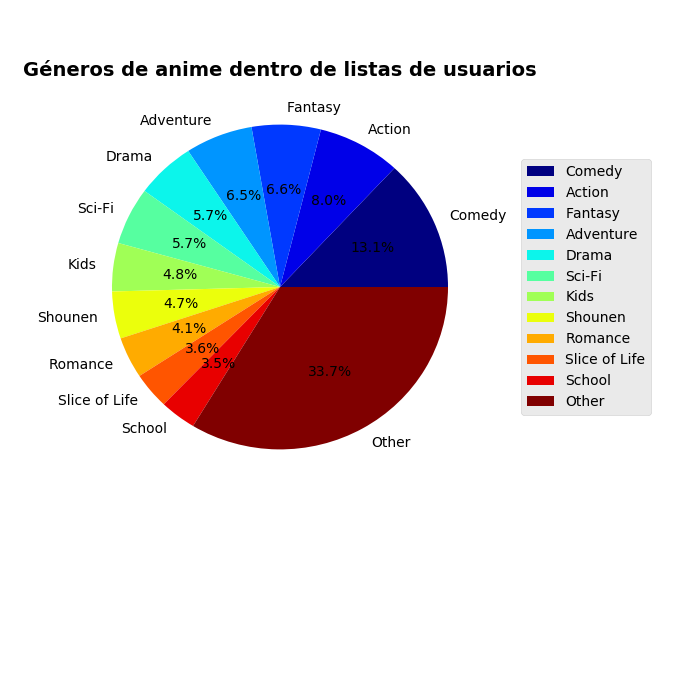

In [9]:
genres_counts = genre_data['genre'].value_counts() 
Otros = pd.DataFrame([genres_counts[12:].sum()], ["Other"])
genres_counts2 = genres_counts[:11].append(Otros)
genre_plot = pd.DataFrame(genres_counts2)

pie = genre_plot.plot.pie(subplots=True, figsize=(7, 7),autopct='%1.1f%%',cmap='jet')

plt.title('Géneros de anime dentro de listas de usuarios', weight='bold', size=14)
plt.legend(bbox_to_anchor=(1.4,0.5), loc="center right", fontsize=10)
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.7)
plt.ylabel('')
plt.show()

Así sabemos cómo se distribuyen los géneros en el total de anime y de anime vistos por cada usuario. Es importante recalcal nuevamente que poseemos solo un pequeño universo de datos de listas de usuarios, por lo que los resultados pueden variar cuando obtengamos más. Sin embargo, estimamos que las proporciones se mantengan casi estables por la distribución total de anime que hay, si hay más de X, es normal que se vea más X.

Ahora queremos saber cómo se distribuyen los puntajes dados por cada usuario a los distintos anime, para ello hicimos la siguiente estadística.

In [20]:
av_genre = user_genre.groupby(as_index=False, by=['genre']).agg({'user_score':np.mean})
av_genre.sort_values(by='user_score', ascending=False, inplace=True)
av_genre.rename(columns={'genre':'Genres', 'user_score':'Average user score'}, inplace=True)
av_genre.reset_index(drop=True, inplace=True)

av_genre.head(10)

,Genres,Average user score
0,Thriller,7.709628
1,Samurai,7.433748
2,Psychological,7.388204
3,Police,7.345594
4,Drama,7.339983
5,Military,7.311072
6,Mystery,7.310141
7,Supernatural,7.273771
8,Historical,7.262771
9,Shounen,7.254452


Podemos ver que nuevamente aparece "Suspenso" como primero en la lista, en este caso aparece como el género con mejor puntuación promedio. Esto nos da una idea de cómo se encuentra distribuido el rango total de puntajes hechos por los usuarios. Para obtener la distribucion real de esto usamos el siguiente código.

<IPython.core.display.Javascript object>


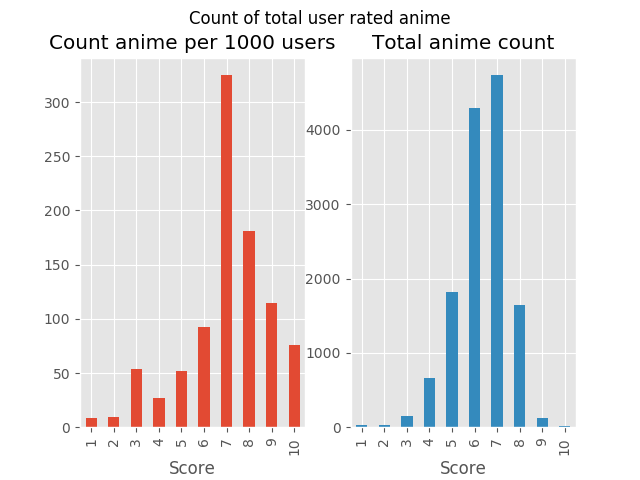

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BCE7D30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C3B94A8>]], dtype=object)

In [11]:
def scale_user_score(scores):
    return np.size(scores) / 1000

anime_average_score = user_data.groupby(by=['user_score']).agg({'user_score':scale_user_score})
anime_average_score.rename(columns={'user_score':'Count anime per 1000 users'}, inplace=True)
anime_average_score.reset_index(inplace=True)
anime_average_score.rename(columns={'user_score':'Score'}, inplace=True)

anime_temp_score = anime_data
anime_temp_score['int_score'] = anime_temp_score['score'].apply(np.round)
anime_total_score = anime_temp_score.groupby(by=['int_score']).agg({'int_score':np.size})
anime_total_score.rename(columns={'int_score':'Total anime count'}, inplace=True)
anime_total_score.reset_index(inplace=True)
anime_total_score.rename(columns={'int_score':'Score'}, inplace=True)

final_score = pd.merge(anime_average_score, anime_total_score, on='Score')
final_score.plot(kind='bar', x='Score', legend=False, title="Count of total user rated anime", subplots=True, layout=(1,2))

En el grafico anterior se muestran 2 graficos de barras, ambos representan como se distribuyen las puntuaciones de anime, pero sobre distintos objetos. En el primer gráfico se muestra cómo están puntuados los anime en las listas de usuarios, como podemos ver, la gran mayoría de los anime fueron catalogados con un 7.
En el caso del segundo gráfico, este representa la distribución de los puntajes promedio totales entre todos los usuarios de MyAnimeList. Este puntaje está incluido por cada anime que recolectamos. Como podemos ver, los puntajes de los usuarios que recolectamos se podrían considerar "inflados".
Se puede ver una irregularidad en el primer gráfico para el puntaje "3". Esto es porque nosotros manualmente rellenamos los anime en estado "dropped" que no tuvieran puntuación con una clasificación de 3.

***

## 3. Metodología y pruebas

Ahora que tenemos conocimiento de cómo nuestros datos estan organizados, y las variaciones que existen, exploramos posibles algoritmos, modelos y librerías que pudieran ayudarnos a modelar nuestros datos de forma que pudiera precedir gustos.

Nuestra primera hipótesis es que si pudieramos clasificar usuarios en distintos grupos, podríamos hacer recomendaciones en base a los anime que X usuario no haya visto, pero que sí hayan visto y les hayan gustado a otros miembros del grupo. Esto se presenta en la siguientes secciones.


### 3.1 Matriz de interacción

Para todos los experimentos que presentaremos, se necesitó de una tabla que contuviera información sobre anime y usuarios al mismo tiempo. Para esto se creó una matriz de interacción, es decir, un mappeo entre lo que cada usuario ha visto y que anime existen. Cada fila de la matriz representa a un usuario, por lo que hay del orden de 4 mil filas. Y cada columna representa a un anime, donde el valor que se encuentra en cada celda de la matriz corresponde al puntaje que ese usuario le dió al anime correspondiente. En caso de no haberlo visto el valor es 0. De esta forma tenemos una matriz de 4.140 por 14.007, la cual es sumamente dispersa, lo que significa que gran parte de la matriz esta compuesta de ceros, y solo algunas celdas son distintas de 0. Aquí en vez de guardar la matriz completa, solo guardamos las coordenadas distintas de 0, de tal forma que primero se cree una matriz de solo ceros para luego reemplazar los valores correspondientes. Para esto se utilizaron las matrices sparse de scipy. El código sobre cómo se construyó esta matriz se encuentra en __[parser.py](https://github.com/juanpablos/anime-recommender/blob/master/src/parser.py)__.


### 3.2 Dimensionalidad

El primer problema con el que chocamos rápidamente al proponernos clasificar usuarios, fue la dimensionalidad de nuestros datos. Con más de 14 mil anime, se tienen más de 14 mil dimensiones que considerar. Además, la matriz de interacción es sumamente dispersa, ya que los usuarios en promedio han visto menos de 200 anime, dejando muchas celdas vacías (en 0).

Para datos dispersos como los nuestros, aplicar PCA no trae los mismos resultados que traería para una matriz más densa. Por esta razón una solución que usamos fue LSA (latent semantic analysis) que nos entrega una matriz con vectores latentes, con una dimension que nosotros especificamos. Esto es principalmente porque LSA no centra los datos antes de computar el SVD (singular value descomposition), lo que permite que funcione mucho más rápido con la representación de matrices dispersas de scipy, además de que entrega una matriz de vectores latentes, que es lo que utilizaremos en el experimento final.


### 3.3 Clustering

Aquí proponemos usar clustering para agrupar usuarios y determinar gustos. Sin embargo, estos experimentos no son usados independientemente, sino más bien usados con el intento de mejorar el modelo final en 3.4.


#### 3.3.1 K-means

Uno de los primeros pasos que tomamos fue usar K-Means para clasificar nuestros datos, en este caso, para clasificar usuarios. En este contexto se hicieron 3 pruebas. Una con las 14 mil dimensiones de la matriz dispersa, es decir con los datos originales; otra con una reducción de dimensiones de 14 mil a mil, y la última reduciendo las dimensiones a 100. El porqué se redujo a mil es porque creemos que si bien 14 mil anime es demasiado, y nadie los ha visto todos, y muy buena parte de ellos tampoco son populares, mil anime no es mucho. Hay muchos usuarios que han visto más de 1.000 series, por lo que consideramos que tener mil valores representativos es una buena medida.

Como no sabemos realmente cuántos grupos de usuarios queremos, usamos el elbow method, que se basa en probar una serie de "K"s, número de clusters, luego calcular la inercia, o la suma del error cuadrático, y graficar este error decrecer. La idea es escojer el K que hace disminuir más el error antes de que este empiece a disminuir menos abruptamente. Como tenemos datos tan dispersos, cláramente el error no se estabilizará fácilmente, pero nos podrá dar una idea de qué valor de K es uno útil para nuestro análisis.

Los graficos obtenidos para el numero original de dimensiones (14 mil), y para mil dimensiones son los siguientes:

![kmeans](elbow_kmeans.png)
![kmeans_lsa](elbow_kmeans_lsa.png)

Como se puede ver, el error no deja de disminuir. Esto es lógico ya que el error se hace 0 solo cuando K=número de elementos. Respaldado parcialmente por los gráficos, decidimos utilizar un K=50, con el cual K-Means le asignó a cada usuario un grupo. No validamos matemáticamente los clusters obtenidos, pero inspecciones manuales sobre algunos grupos de clusters selectos resultó en agrupaciones correctas de usuarios con gustos similares. Por supuesto, este tipo de evaluación no tiene respaldo formal, pero es una señal de que el método en efecto tiene resultados.

Una vez sabíamos el número de clusters a utilizar creamos funciones que corrieran K-Means y guardaran en un archivo el cluster asociado a cada usuario.


#### 3.3.2 Ki-Means

Basado en K-means, Ki-means es nuestra implementación del algoritmo para hacer clustering sobre datos dispersos. Nuestra hipotesis para hacer esto es la siguiente: asumamos existen solo 3 anime tal que cada anime es representado por su índice en un vector de 3 valores. Digamos Pedro puso un 7 al primer anime, no ha visto el segundo y puso un 1 al tercero, esto sería (7, 0 ,1). Luego tenemos a Pablo que puso los siguientes puntajes (7, 10 , 0), es decir no ha visto el tercero. Finalmente está Alejandro con (2, 10, 5). En un escenario como este K-means con K=2 clasificaría juntos a Pablo y Alejandro, ya que su distancia euclideana es efectivamente menor. Sin embargo, nosotros proponemos que los que realmente se parecen más son Pedro con Pablo, ya que no tenemos información sobre si a Pedro le gustará o no el segundo anime, y tampoco tenemos información sobre el 3er anime para Pablo, pero ambos pusieron un 7 al primer anime, por lo que su distancia sería 0.

Es basado en esta hipótesis que implementamos K-means de forma que considerara solo variables comunes entre puntos, salvo el centroide, en el cual se tomaban todas sus variables en cuenta. En pocas palabras esta implementación no considera la variables que tiene 0 en los puntos del dataset, es decir, no considera los anime que los usuarios no han visto cuando interactúan entre ellos. El código de la implementación se encuentra en __[ki_means.py](https://github.com/juanpablos/anime-recommender/blob/master/src/ki_means.py)__. La implementacion no contiene ningun tipo de optimizacion, por lo que toma un tiempo elevado para agrupar en clusters. Por esta razón, en vez de utilizar el elbow method para seleccionar el numero de clusters, simplemente elegimos 50, como en K-Means.

### 3.4 Factorization Machine

Las Factorization Machines son un concepto relativamente nuevo introducido el 2010 por Steffen Rendle [1]. Las FM son un modelo que permite simular la gran mayoría de los modelos de factorización de matries mediante feature engineering, que básicamente es entender sobre el dominio en que se está trabajando para crear características para entrenar modelos de machine learning. Según su mismo inventor, las FM son comparables a los SVMs (support vector machine) con un kernel polinomial, y la factorización de matrices. La diferencia mayor yace en que la FM tiene una complejidad de tiempo lineal, mietras que el SVM es cuadratico para el mismo input. Además, la FM funciona muy bien con datos dispersos a cambio de no tener buenos resultados con datos densos, que es lo contrario al SVM.

La parte importante que se aplica a nuestro problema de recomendar series de anime, es que la FM pueden considerar metadata, ademas de solo la matriz de interacción, creando un modelo híbrido. La mayoría de los sistemas recomendadores toman una matriz (usuario, item, puntuación), pero hay veces en las que también se tienen datos externos a esas interacciones, como pueden ser tags, géneros de música, pre clasificación de usuarios, etc. Esta es justamente nuestra situación, tenemos géneros, múltiples, para cada anime, también estudios de animación y directores. Además podríamos considerar edad, sexo y país de residencia de los usuarios a evaluar, lo cual se convierte en más carácteristicas extra, que llamaremos metadata.

En este proyecto utilizamos LightFM [2], una librería de Python para trabajar con factorization machines que implementa un modelo híbrido con feedback explicito e implicito basada en el ranking de items. Para el parseo de datos, generación de matrices y selección de caracteristicas se crearon una serie de funciones auxiliares que crean una capa de abstracción para la fácil manipulación de datos, esto se encuentra en __[data_utils.py](https://github.com/juanpablos/anime-recommender/blob/master/src/data_utils.py)__.


#### 3.4.1 Testing

Para testear el modelo entrenado existen 2 maneras. Una es teórica, usando técnicas de evaluación, que es lo que usaremos. Sin embargo, las FM y los sistemas recomendadores en general tienden a ser evaluadas empíricamente, usando usuarios que califiquen al modelo, en vez de usar una métrica teórica para hacerlo. Esto ya que con tantos items que recomendar, no es realmente posible verificar si efectivamente al usuario le gustará o no una recomendacion si no es preguntandole a él o ella personalmente.

El conjunto de testing que elegimos para la verificación teórica del modelo consiste en remover el 25% de los anime vistos por cada usuario, de forma aleatoria, y agregarlos en otra matriz, dejando como "no visto" el anime removido en la matriz original. Es decir, tenemos una matriz con el 25% de los anime visto por cada usuario que utilizaremos para verificar el modelo.


#### 3.4.2 Métricas

Para evaluar el modelo requerimos de métricas que determinen la correctitud de este. LightFM provee de 2 funciones representativas sobre modelos recomendadores que ayudan a tener una idea de lo que ocurre con las recomendaciones y qué tan acertadas son. Las métricas usadas son las siguientes:

- __AUC score__: se refiere al area bajo la curva de la matriz de confución para distintos umbrales, y se interpreta como qué tan probable es que un verdadero positivo quede rankeado más "arriba" (o antes) que un falso negativo. Esto no considera qué tan antes debe estar rankeada, sino que solo si es antes o despues.
- __Precision at k__: se refiere al número de items que son verdaderos positivos dentro de las k primeras posiciones del ranking. Esto signfica que pido al recomendador que me diga el top K, luego comparo esos K items y veo si se encuentran en el set de prueba para ese usuario, esto corresponde a la cantidad de correctas partido por K. Se puede notar que para un número de items arbitrariamente grande la precisión deja de tener sentido ya que es muy dificil que seleccione exactamente algún item en el set de prueba.

En las evaluaciones utilizamos un k=10 para el precision at k.


#### 3.4.3 Resultados

Se hicieron distintas pruebas para evaluar el modelo. Primero se utilizó solo la matriz de interacción, convirtiendo la FM en un modelo colaborativo tradicional, tal como un sistema recomendador común. Luego añadimos caracteristicas adicionales, es decir, la metadata que tenemos sobre los anime. 

Aquí se hicieron 4 pruebas, una para la matriz de interacción independiente, luego añadiendo tags de géneros, luego de los directores de cada serie y finalmente los estudios de animación que animaron cada una de las series. Los resultados de estas pruebas se encuentran en la siguiente tabla:

In [15]:
fm_features = pd.read_csv("../Data/fm_results_features.csv")
fm_features

,model,train_score,test_score,precision_at_k_train,precision_at_k_test
0,basic,0.978003,0.974733,0.576184,0.443755
1,genre,0.979399,0.975994,0.585531,0.451607
2,directors,0.978994,0.975405,0.576739,0.446724
3,studios,0.978610,0.975123,0.577319,0.445276


En las columnas se encuentra "score" y "precision at k". "Score" corresponde al AUC score, y precision at K corresponde a la métrica con el mismo nombre, ambas explicadas en 3.4.2. Ambas métricas se ejecutan sobre el set de entrenamiento y de pruebas, para verificar qué tan bien los datos se adecúan al modelo. El modelo "basic" corresponde al modelo tradicional para sistemas recomendadores, solo con una matriz de interacción.

Se puede ver que los resultados son bastante buenos, especialmente para el AUC score, obteniendo más de un 97% de aciertos en ambos conjuntos de datos. Dicho esto, la métrica solo mide que un anime que se sabe es correcto quede rankeado en una posición superior a uno que se sabe que es falso (no le gusta al usuario), sin considerar (o desconociendo) los anime que el usuario no ha visto. Precision at K también presenta buenos resultados, considerando que en general este valor se encuentra alrededor de un 30%.

Dentro de todas las pruebas, se puede ver que los tags de género (genre) son las que más elevan las métricas utilizadas (alrededor de un 1%), por lo que utilizamos estas para el próximo experimento. Las clusters encontrados en 3.3 se utilizaron como tags de los usuarios, una pre clasificación que permite extender el modelo a usuarios que no se encuentran entre los datos de entrenamiento. Esta prueba consiste en agregar al modelo no solo los tags de género, sino también los de cada cluster encontrado anteriormente, estos resultados se presentan en la siguiente tabla:

In [16]:
fm_genre_user = pd.read_csv("../Data/fm_results_user_features.csv")
fm_genre_user

,model,train_score,test_score,precision_at_k_train,precision_at_k_test
0,kmeans_lsa100,0.978923,0.976073,0.579879,0.451166
1,kmeans_lsa1000,0.978594,0.975890,0.573140,0.447141
2,kimeans,0.977854,0.975201,0.569203,0.433840
3,kmeans,0.978900,0.976123,0.577005,0.447583


Se puede ver que los valores disminuyeron en comparación con el modelo considerando solo los tags de género. Esto puede deberse a que los clusters no son una buena métrica, pero de todas maneras permite la extensibilidad del modelo a más datos. Se puede apreciar sin embargo, que Ki-Means es el método que obtiene menores valores, que es lo contrario a lo que esperabamos originalmente. Esto puede deberse a que como cambiamos el algoritmo, es probable que haya dejado de converger, cosa que no verificamos al momento de implementarlo. Finalmente, entre todos los clusters, K-Means con LSA a 100 dimensiones es el que obtiene mejores resultados.

***

## 4. Conclusiones

Como conclusiones de nuestro trabajo, destacamos que teóricamente verificado, nuestro modelo es bastante bueno, clasificado como muy preciso. Esto habrá que verificarlo empiricamente para obtener una versión de la realidad. Dicho esto, otro detalle que tiene el modelo actual es el reducido número de usuarios considerados, que son solo 4 mil, obtener más podría cambiar los resultados. Dentro de la FM, la metadata que resultó ser más útil para recomendar fueron los géneros, aunque en la práctica los géneros, estudios y directores podrían usarse en conjunto.

Los clusters como características extra sobre usuarios bajan el accuracy final del modelo, pero esto podría ser usado para la extensibilidad del modelo para usuarios sin precedentes, en vez de re entrenar el modelo cada vez que ingresa un usuario nuevo.

Ki-means, nuestra implementacion de K-Means, no funcionó como esperábamos, dando un resultado incluso peor que K-Means. Esto puede deberse a que en realidad Ki-Means no converja y simplemente termina por exceso de iteraciones. Esto puede suceder ya que no se verificó matemáticamente que este algoritmo convergiese ni que representara distancias en el espacio. Solamente vimos que se adecuara a lo que buscabamos superficialmente.

***

## 5. Trabajo Futuro

Como trabajo futuro tenemos varias propuestas por lo que las presentaremos en un formato de lista para mayor claridad:

- Obtener más usuario: actualmente solo tenemos del orden de 4 mil usuarios. Esto es solo una fracción de los millones presentes en MAL, por lo que obtener el total o al menos un millón de usuarios podría variar fuertemente nuestros resultados, ya que el universo a considerar es muchísimo mayor, aunque el universo de características latentes también aumenta.
- Verificación empírica: generalmente los sistemas recomendadores son verificados empíricamente mediante un estudio de usuarios, por lo que una verificación de este tipo nos ayudaría a comprender qué tan preciso es realmente nuestro modelo.
- Ensamble de modelos: actualmente es poco probable que las grandes empresas que utilizan estos sistemas (Amazon, Google, etc), utilicen solo 1 modelo a la vez. En general son varios modelos que son "pegados" entre sí, para crear un modelo como el conjunto de ellos. Esto frecuentemente aumenta la precisión y expresividad de los modelos, y es actualmente la técnica más común utilizada en competencias de datos, como las gestadas en Kaggle.
- Reemplazar Ki-Means: en vez de crear un algoritmo nuevo como Ki-Means, se podría cambiar la función de distancia de K-Means, de tal manera que refleje la métrica que queremos proyectar. Por lo tanto, en vez de utilizar una métrica para espacios métricos euclidianos, podríamos utilizar una función como el coseno, de tal forma que distancias entre 0 y otra, sean 0 y no una proporción sobre el otro valor.

## Referencias
[1] Rendle, S. (2010). Factorization Machines.. In G. I. Webb, B. Liu, C. Zhang, D. Gunopulos & X. Wu (eds.), ICDM (p./pp. 995-1000), : IEEE Computer Society. ISBN: 978-0-7695-4256-0 

[2] Kula, M. (2015). Metadata Embeddings for User and Item Cold-start Recommendations.. In T. Bogers & M. Koolen (eds.), CBRecSys@RecSys (p./pp. 14-21), : CEUR-WS.org. 